In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 120,
    "figure.figsize": (10, 6)
})

Load dataset with dtype mapping

In [15]:
dtype_map = {
    "tweet_id": str,
    "user_id": str,
    "verified": str,
    "default_pic": str
}

data_path = "v2.tsv"
df = pd.read_csv(data_path, sep="\t", dtype=dtype_map)

# quick info
print("Loaded rows:", len(df))

Loaded rows: 162386


Filter language (english only), parse date, build year & quarter

In [ ]:
df = df[df["language"] == 1].copy()   # filter

# parse date column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])  # drop rows with invalid dates

# year and quarter
df["year"] = df["date"].dt.year
df["quarter"] = df["date"].dt.quarter
df["year_quarter"] = df["year"].astype(str) + "-Q" + df["quarter"].astype(str)

102066 rows after filtering non-English tweets and invalid dates


Assigning classess to labels and defining priority when tie

In [ ]:
def assign_class(row):
    votes = {
        "Normal": row["label_0"],
        "Offensive": row["label_1"],
        "Hate": row["label_2"]
    }
    max_vote = max(votes.values())
    candidates = [cls for cls, v in votes.items() if v == max_vote]

    # Priority: Hate > Offensive > Normal
    if "Hate" in candidates:
        return "Hate"
    elif "Offensive" in candidates:
        return "Offensive"
    else:
        return "Normal"

df["final_label"] = df.apply(assign_class, axis=1)

Quarterly distribution of classess

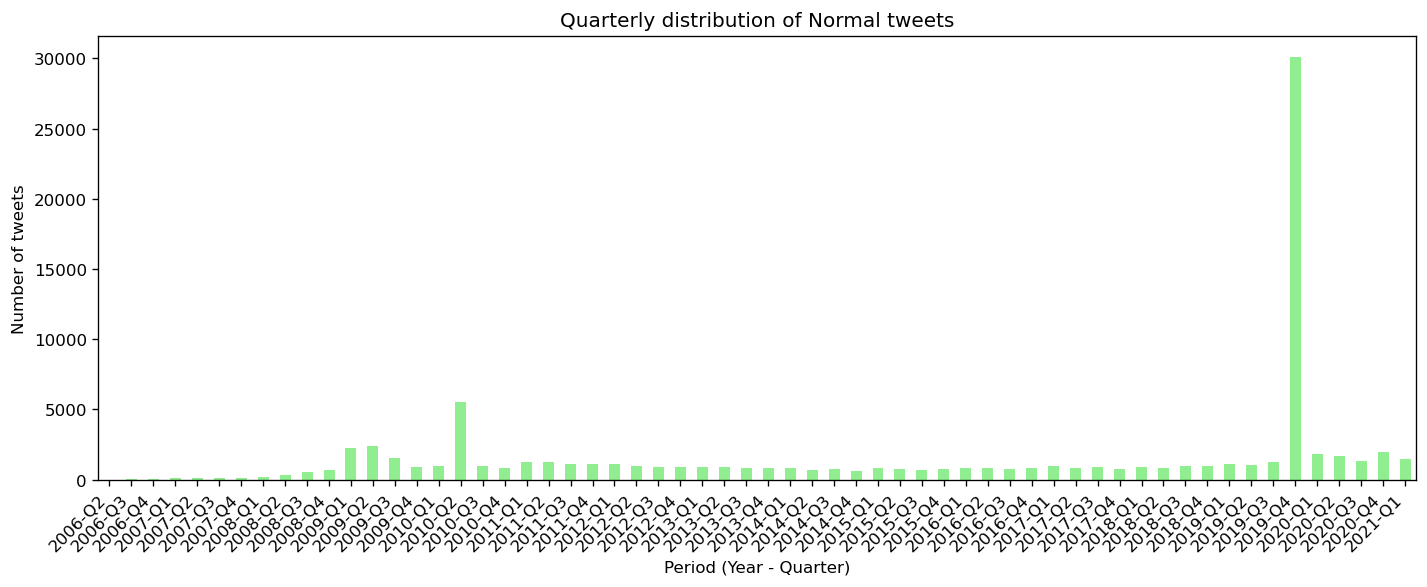

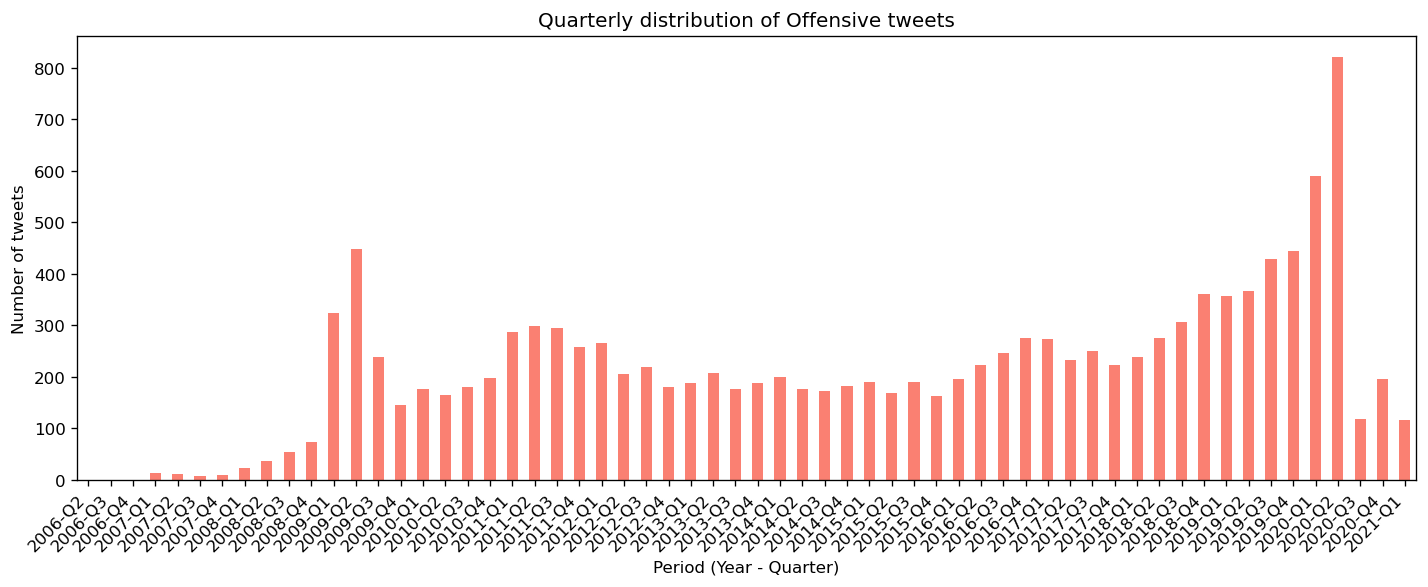

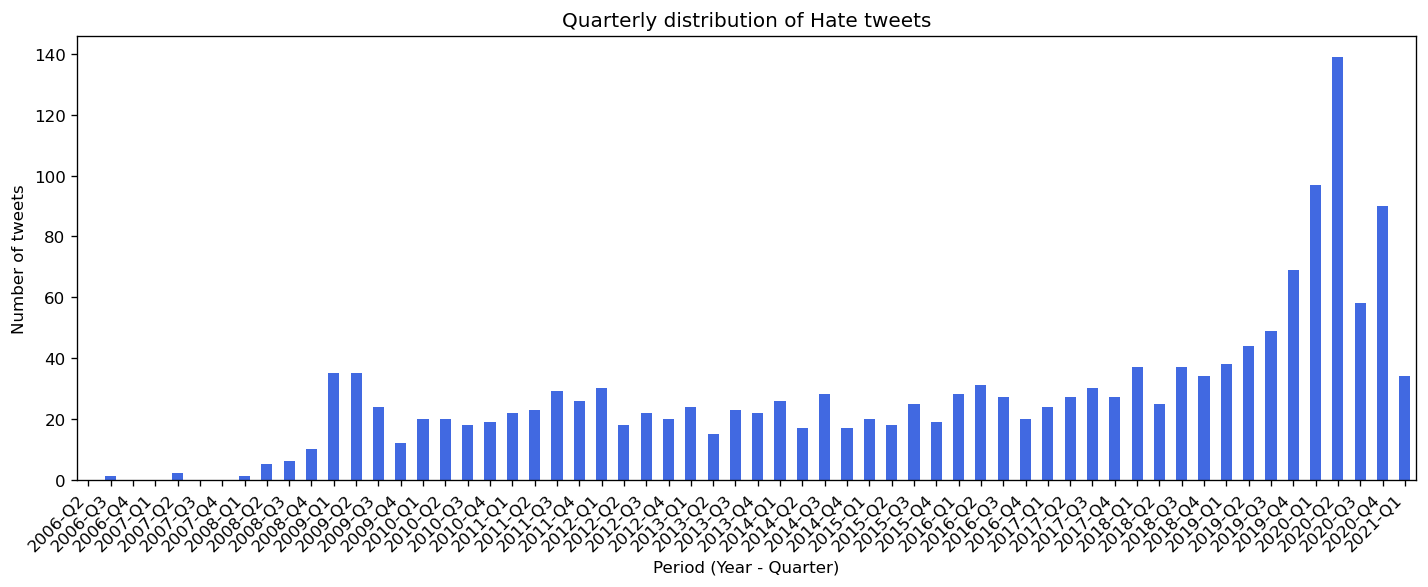

In [ ]:
# Cell 6: quarterly counts per class (3-month bins), one chart per class
quarterly_counts = df.groupby(["year_quarter", "final_label"]).size().unstack(fill_value=0)

# ensure chronological order of the index
quarterly_counts = quarterly_counts.sort_index()

class_colors = {"Normal": "lightgreen", "Offensive": "salmon", "Hate": "royalblue"}

for cls in ["Normal", "Offensive", "Hate"]:
    plt.figure(figsize=(12, 5))
    
    data = quarterly_counts[cls] if cls in quarterly_counts.columns else pd.Series(0, index=quarterly_counts.index)
    data.plot(kind="bar", color=class_colors[cls])
    
    plt.title(f"Quarterly distribution of {cls} tweets")
    plt.ylabel("Number of tweets")
    plt.xlabel("Period (Year - Quarter)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Overall class distribution

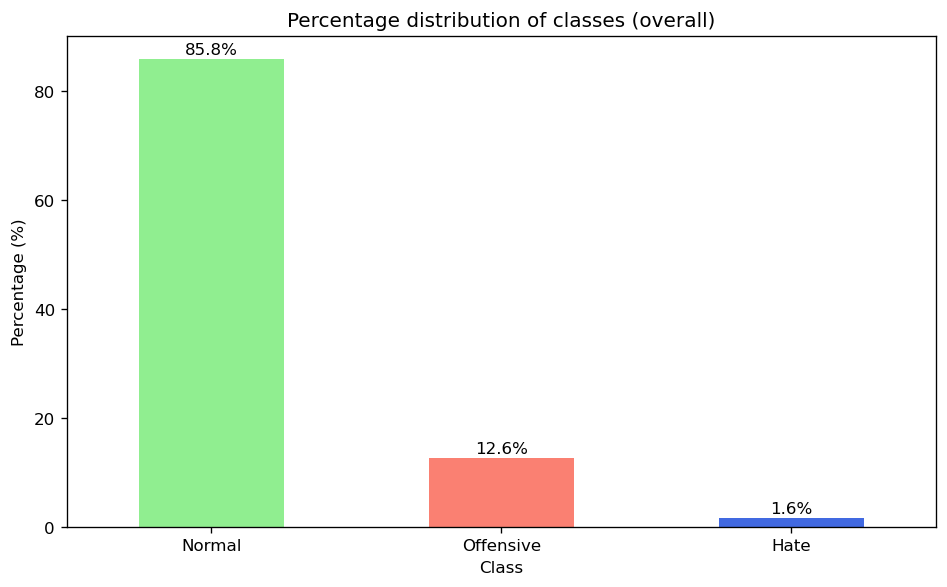

In [ ]:
class_distribution = df["final_label"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
class_distribution.reindex(["Normal", "Offensive", "Hate"]).plot(kind="bar", color=["lightgreen", "salmon", "royalblue"])
plt.title("Percentage distribution of classes (overall)")
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.xticks(rotation=0)

# add labels
for i, val in enumerate(class_distribution.reindex(["Normal", "Offensive", "Hate"])):
    plt.text(i, val + 1, f"{val:.1f}%", ha="center")

plt.tight_layout()
plt.show()

Class distribution per year

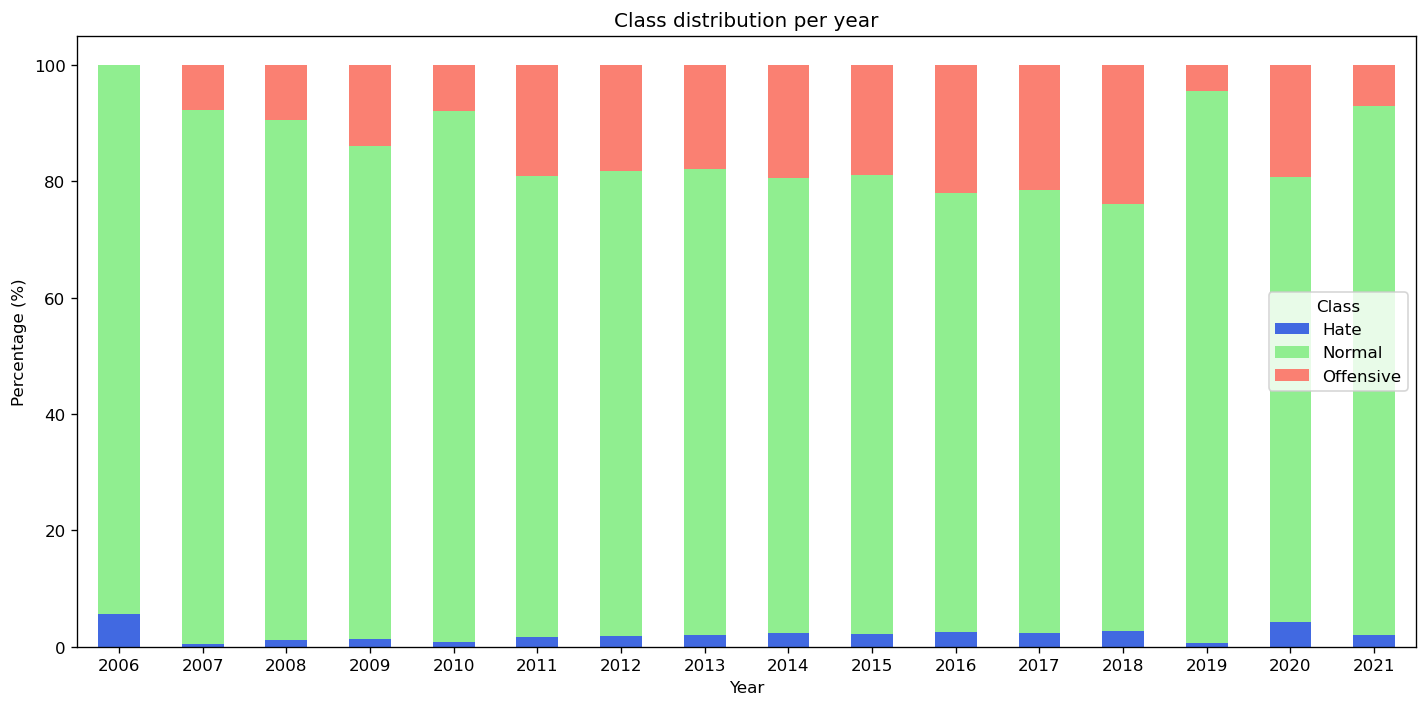

In [ ]:
# Cell 8: yearly stacked percentage (each year sums to 100%)
yearly_counts = df.groupby(["year", "final_label"]).size().unstack(fill_value=0).sort_index()
yearly_percent = yearly_counts.div(yearly_counts.sum(axis=1), axis=0) * 100

yearly_percent.plot(kind="bar", stacked=True, figsize=(12, 6), color={"Normal": "lightgreen", "Offensive": "salmon", "Hate": "royalblue"})

plt.title("Class distribution per year")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.tight_layout()
plt.show()

Class distributions across years

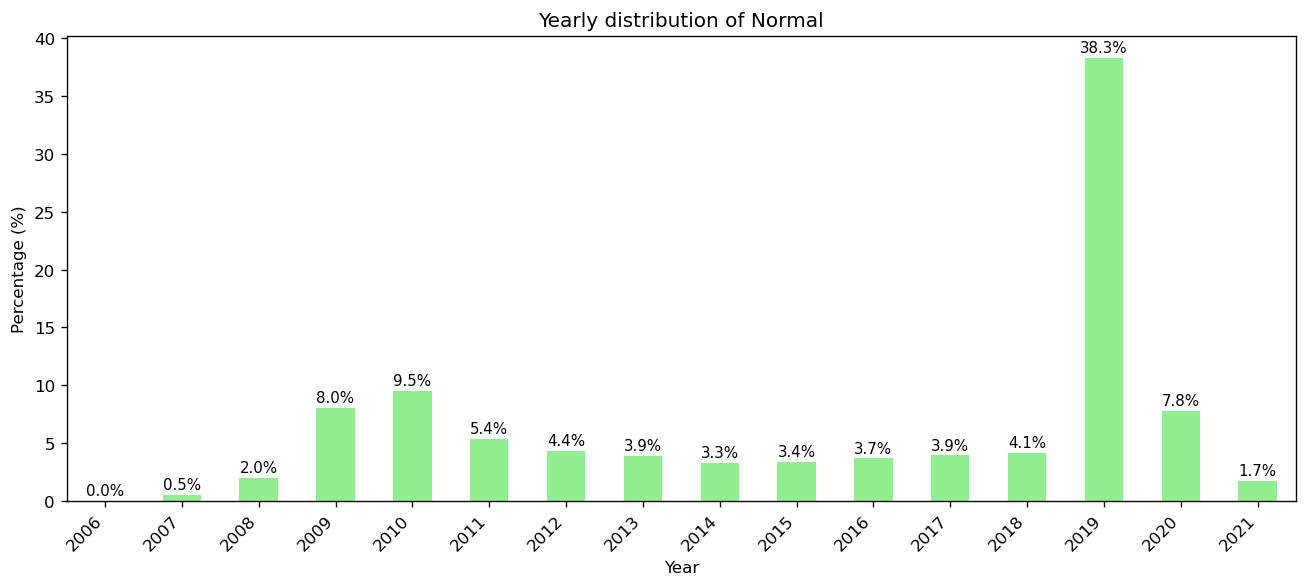

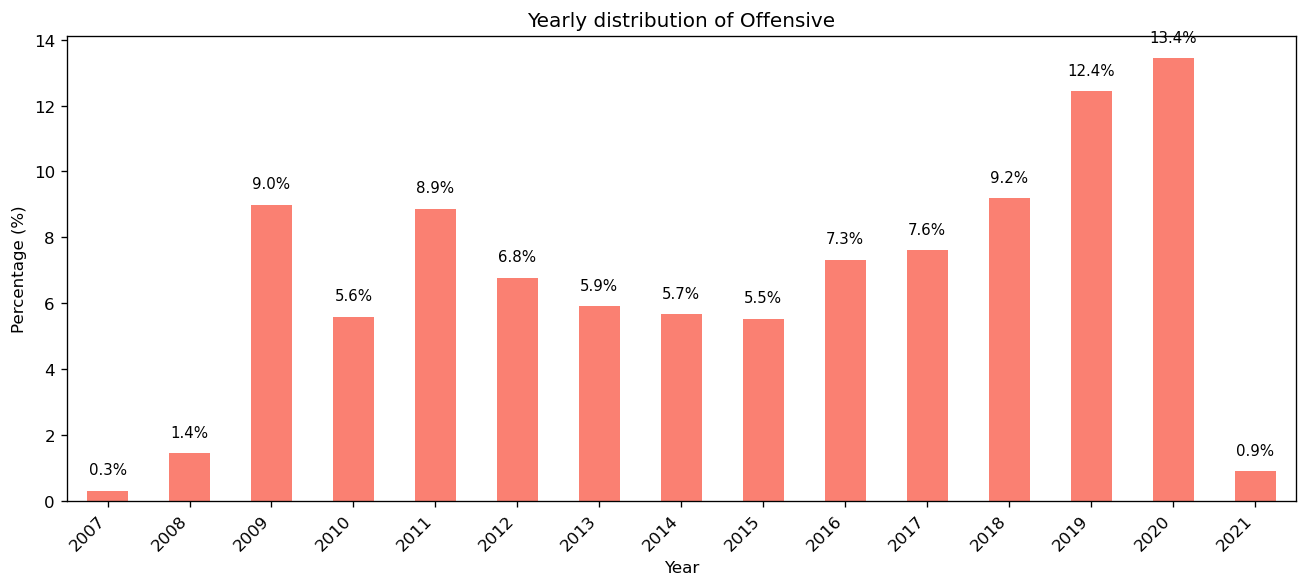

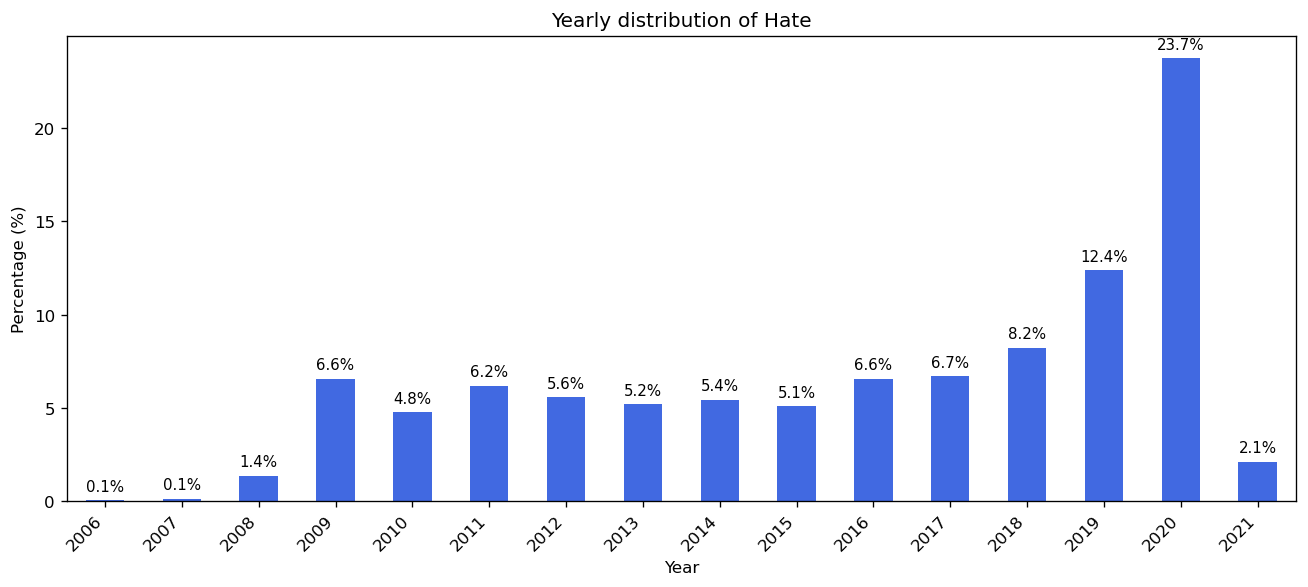

In [ ]:
classes = ["Normal", "Offensive", "Hate"]
colors = {"Normal": "lightgreen", "Offensive": "salmon", "Hate": "royalblue"}

for cls in classes:
    df_cls = df[df["final_label"] == cls]
    if df_cls.empty:
        print(f"No data for class {cls}, skipping.")
        continue

    yearly_counts_cls = df_cls.groupby("year").size().sort_index()
    yearly_percent_cls = yearly_counts_cls / yearly_counts_cls.sum() * 100

    plt.figure(figsize=(11, 5))
    yearly_percent_cls.plot(kind="bar", color=colors[cls])
    plt.title(f"Yearly distribution of {cls}")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Year")
    plt.xticks(rotation=45, ha="right")

    # add labels above bars
    for i, val in enumerate(yearly_percent_cls):
        plt.text(i, val + 0.5, f"{val:.1f}%", ha="center", fontsize=9)

    plt.tight_layout()
    plt.show()


Yearly distribution of data overall

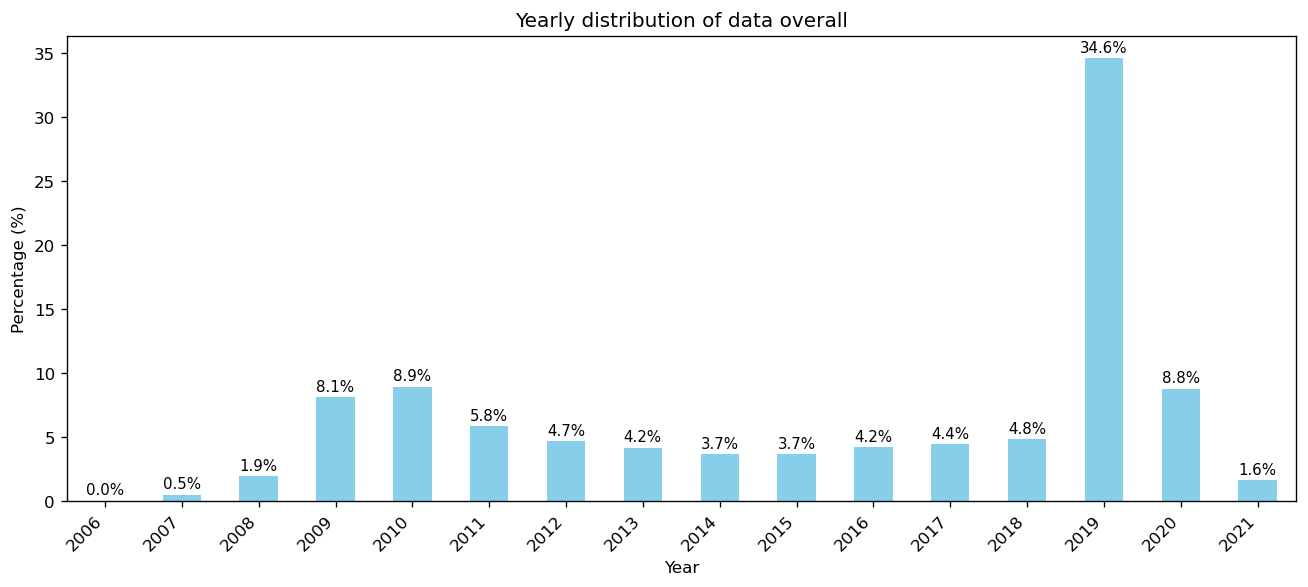

In [19]:
yearly_counts_all = df.groupby("year").size().sort_index()
yearly_percent_all = yearly_counts_all / yearly_counts_all.sum() * 100

plt.figure(figsize=(11, 5))
yearly_percent_all.plot(kind="bar", color="skyblue")
plt.title("Yearly distribution of data overall")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.xticks(rotation=45, ha="right")

# add labels above bars
for i, val in enumerate(yearly_percent_all):
    plt.text(i, val + 0.5, f"{val:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()